In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sympy import *

### cleaning

In [ ]:
df_p = pd.read_csv('data/custom_ppds_output_2023-01-31.csv')
df_p

In [ ]:
df_p.sort_values(by='slot', ascending=True, inplace=True)

In [ ]:
df_p.drop_duplicates(subset=['slot'], keep='first', inplace=True)

In [ ]:
df_p.reset_index(drop=True, inplace=True)

In [ ]:
df_p.rename(columns={'buidler_pubkey': 'builder_pubkey'}, inplace=True)
df_p.rename(columns={'buidler_name': 'builder_name'}, inplace=True)


In [ ]:
df_p.info()

In [ ]:
print(df_p['builder_name'].unique())
df_p = df_p[['slot', 'block_hash', 'block_reward', 'gas_used', 'validator_pubkey', 'builder_pubkey', 'builder_name', 'relay_name']]


In [ ]:
df_p['boosted'] = True

In [ ]:
slot = np.arange(4700013, df_p['slot'].max())
# first slot after Ethereum merge https://etherscan.io/block/15537394
df = pd.DataFrame(slot, columns = ['slot'])



In [ ]:
df = df.merge(df_p, how='left', on='slot')
#df['builder_name'].fillna('No builder', inplace=True)
#df['builder_pubkey'].fillna('No builder', inplace=True)
df['builder_name'].replace('Ø\x83\x01\x0b\x84geth\x88go1.19.1\x85linux', 'coda_geth_linux', inplace=True)


In [ ]:
df['boosted'].fillna(False, inplace=True)

In [ ]:
df

### descriptive statistics

In [ ]:
slots_per_hour = 5*60
slots_per_day = 5*60*24

total_slots = len(df)
total_epochs = int(len(df)/32)
total_days = total_slots / slots_per_day

In [ ]:
#fltr = 'builder_name'
#fltr_name = 'entity'

fltr = 'builder_pubkey'
fltr_name = 'pubkey'

df['count'] = 1
df['position'] = 1
count = 0
for i in range(0, len(df)):
    check = (df[fltr].iloc[i] == df[fltr].iloc[i-1]) & (df[fltr].iloc[i] != 'Unknown') & (df[fltr].iloc[i] != 'No builder')
    
    if check == True:
        if count == 0:
            count = 2
        else:
            count += 1

    elif (check == False) & (count == 0):
            continue

    elif (check == False) & (count != 0):
        for j in range(1, count+1):
            df['count'].iloc[i-j] = count
            df['position'].iloc[i-j] = count+1-j

        count = 0




In [ ]:
#df['block_reward'].fillna((df[df['count'] == 1]['block_reward'].mean()), inplace=True)

In [ ]:
df_backup = df.copy()

In [ ]:
df.groupby(df['count']).size()

In [ ]:
stat = df.groupby(df['count']).size().values

temp = df['count'].unique()
temp.sort()

print('In a dataset of', len(df), 'blocks', int(len(df)*12/60/60/24), 'days we find:')

for i, x in enumerate(temp):
    stat[i] = stat[i]/x
    
    print(stat[i], 'instances of', x, 'consecutive blocks')

print('proposed by the same builder')

In [ ]:
print(stat[0]/len(df), '% normal blocks')
print(stat[1]*2/len(df), '% k=2 blocks')
print(stat[2]*3/len(df), '% k=3 blocks')
print(stat[3]*4/len(df), '% k=4 blocks')
print(1-stat[0]/len(df)-stat[1]*2/len(df)-stat[2]*3/len(df)-stat[3]*4/len(df), '% k>= 5 blocks')

In [ ]:
slots_per_day*(stat[1]/len(df))

In [ ]:
print(df['builder_name'].unique())
print(df.groupby(df['builder_name']).size().sort_values(ascending=False))

In [ ]:
df.groupby(df['builder_pubkey']).size()

In [ ]:
df.groupby(df['builder_name']).size()

In [ ]:
#cannot match
len(df[df['builder_name'] == 'Unknown'])/len(df[df['boosted'] == True])

In [ ]:
df.tail(10)

In [ ]:
df['block_reward'].sum()

In [213]:
lst = list(df['builder_name'].unique()) #drop na
lst = lst[1:]

calc = pd.DataFrame(lst, columns = ['builder_name'])

temp_lst = []
for x in lst:
    temp_lst.append(len(df[df['builder_name'] == x]))

calc['slots'] = temp_lst

calc['share'] = np.round(calc['slots']/len(df),4)

for i in range(1,20+1):
    temp_lst = []
    
    for x in lst:
        temp_lst.append(int(len(df[(df['builder_name'] == x) & (df['count'] == i)])/i))
    
    name = f'k_{i}'
    calc[name] = temp_lst


In [214]:
calc.sort_values(by=['share'], ascending=False, inplace=True)
calc = calc.drop(calc[calc['builder_name'] == 'Unknown'].index)
calc.reset_index(drop=True, inplace=True)
calc = calc.iloc[:,0:13]

In [216]:
totals = calc.sum()
calc = calc.append(totals, ignore_index=True)
calc.rename(index={9: 'Total'}, inplace=True)
calc['builder_name'].iloc[9] = ''

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_25380/1281499864.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  calc = calc.append(totals, ignore_index=True)


In [221]:
calc

,builder_name,slots,share,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
0,flashbots,207603,0.2088,134724,24898,5319,1194,285,95,26,13,3,2
1,builder0x69,156094,0.1570,100699,18727,4134,916,256,66,21,2,4,0
2,bloxroute,110822,0.1114,82369,10893,1685,293,67,10,4,1,1,0
3,beaverbuild.org,105826,0.1064,69033,11596,2737,809,231,78,41,14,8,3
4,blocknative,32836,0.0330,29140,1565,140,21,10,2,0,0,0,0
5,https://eth-builder.com,30982,0.0312,25962,2051,249,39,3,0,0,0,0,0
6,coda_geth_linux,26921,0.0271,24295,1147,93,12,1,0,0,0,0,0
7,eden,7397,0.0074,7293,52,0,0,0,0,0,0,0,0
8,manifold,3478,0.0035,3427,24,1,0,0,0,0,0,0,0
Total,,681959,0.6858,476942,70953,14358,3284,853,251,92,30,16,5


In [329]:
calc.rename(columns={'builder_name': 'builder entity'}, inplace=True)
calc.rename(columns={'slots': 'blocks'}, inplace=True)
calc.rename(columns={'k_1': 'k=1'}, inplace=True)
calc.rename(columns={'k_2': 'k=2'}, inplace=True)
calc.rename(columns={'k_3': 'k=3'}, inplace=True)
calc.rename(columns={'k_4': 'k=4'}, inplace=True)
calc.rename(columns={'k_5': 'k=5'}, inplace=True)
calc.rename(columns={'k_6': 'k=6'}, inplace=True)
calc.rename(columns={'k_7': 'k=7'}, inplace=True)
calc.rename(columns={'k_8': 'k=8'}, inplace=True)
calc.rename(columns={'k_9': 'k=9'}, inplace=True)
calc.rename(columns={'k_10': 'k=10'}, inplace=True)

calc['builder entity'].replace('coda_geth_linux', 'x85linux', inplace=True)
calc['builder entity'].replace('https://eth-builder.com', 'eth-builder.com', inplace=True)
calc['builder entity'].replace('', 'Total', inplace=True)

In [331]:
calc.to_csv('result_tables/leaderboard_entity.csv', index=False)

In [327]:
calc

,builder entity,slots,share,k=1,k=2,k=3,k=4,k=5,k=6,k=7,k=8,k=9,k=10
0,flashbots,207603,0.2088,134724,24898,5319,1194,285,95,26,13,3,2
1,builder0x69,156094,0.1570,100699,18727,4134,916,256,66,21,2,4,0
2,bloxroute,110822,0.1114,82369,10893,1685,293,67,10,4,1,1,0
3,beaverbuild.org,105826,0.1064,69033,11596,2737,809,231,78,41,14,8,3
4,blocknative,32836,0.0330,29140,1565,140,21,10,2,0,0,0,0
5,eth-builder.com,30982,0.0312,25962,2051,249,39,3,0,0,0,0,0
6,x85linux,26921,0.0271,24295,1147,93,12,1,0,0,0,0,0
7,eden,7397,0.0074,7293,52,0,0,0,0,0,0,0,0
8,manifold,3478,0.0035,3427,24,1,0,0,0,0,0,0,0
Total,Total,681959,0.6858,476942,70953,14358,3284,853,251,92,30,16,5


In [ ]:
test = pd.DataFrame(lst, columns = ['builder_name'])

for i in range(1, 10+1):
    data_temp = []
    
    for x in lst:
        data_temp.append(df[(df['builder_name'] == x) & (df['count'] == i)]['block_reward'].mean())
    
    name = f'k_{i}'
    test[name] = data_temp

In [ ]:
totals = test.mean()

In [ ]:
test = test.append(totals, ignore_index=True)
test.rename(index={10: 'Mean'}, inplace=True)

In [ ]:
test = test.iloc[:,1:11]

In [ ]:
test.fillna('', inplace = True)
test

In [ ]:
test = test.drop(3)
test.reset_index(drop=True, inplace=True)

In [ ]:
df['epoch'] = 1663224179

In [ ]:
def multiply_row_index(df, column_name):
    for index, row in df.iterrows():
        df.at[index, column_name] = row[column_name] + index*12
    return df

df = multiply_row_index(df, 'epoch')

In [ ]:
df['date'] = pd.to_datetime(df['epoch'],  unit='s', utc=True)
#df['date'] = df['date'].dt.strftime('%d-%m-%Y %H:%M:%S')

In [ ]:
df.to_csv(f'data/df_{fltr_name}.csv', index=False)

In [ ]:
df = pd.read_csv('data/df_entity.csv')
df['date'] = pd.to_datetime(df['epoch'],  unit='s', utc=True)
fltr_name = 'entity'
#df['date'] = df['date'].dt.strftime('%d-%m-%Y %H:%M:%S')

In [ ]:
fltr_name = 'entity'

### plotting descriptive

In [ ]:
df['boosted'].rolling(slots_per_day, min_periods=1).sum()/slots_per_day

In [ ]:
fig, ax = plt.subplots(figsize =(10, 5))

ax.plot(df['slot'], df['boosted'].rolling(slots_per_day*7, min_periods=1).sum()/(slots_per_day*7))

# ax.ticklabel_format(style='plain')

ax.grid(axis='y', linestyle='--', linewidth=.5)

s = df['slot'].iloc[0]
o = df[df['date'] >= '2022-10-01 00:00:00']['slot'].values[0]
n = df[df['date'] >= '2022-11-01 00:00:00']['slot'].values[0]
d = df[df['date'] >= '2022-12-01 00:00:00']['slot'].values[0]
j = df[df['date'] >= '2023-01-01 00:00:00']['slot'].values[0]
f = df['slot'].iloc[-1]


plt.xticks([s, o, n, d, j, f], ['15 Sep 22', 'Oct 22', 'Nov 22', 'Dec 22', 'Jan 23', 'Feb 23'])
       
left, right = plt.xlim()
ax.set_xlim(left+1, right-0)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

plt.savefig(f'figures/mev_boost.png')

plt.show()

In [ ]:
bins = np.arange(df['slot'].min(), df['slot'].max(), slots_per_day)
data = []
for i in range(0, len(bins)-1):
        data.append(df[(df['slot'] >= bins[i]) & (df['slot'] < bins[i+1])]['block_reward'].mean())

In [ ]:
fig, ax = plt.subplots(figsize =(12, 6))

ax.bar(np.arange(1,len(data)+1), data, width = 0.5)
ax.grid(axis='y', linestyle='--', linewidth=.5)

left, right = plt.xlim()
ax.set_xlim(left+5, right-5)

ax.set_ylabel('Builder payment')
ax.set_xlabel('Day')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

# show plot
plt.show()

ToDo add percentage; trend line; rate of increase..

### plotting analysis

In [ ]:


slc = df[df['count'] <= 10]
slc.dropna(subset=['block_reward'], inplace=True)

temp = slc['count'].unique()
temp.sort()

data = []
for x in temp:
    data.append(list(slc[slc['count']==x]['block_reward']))

fig, ax = plt.subplots(figsize =(8, 8))

ax.boxplot(data, showfliers=False)
ax.grid(axis='y', linestyle='--', linewidth=.5)

ax.set_ylabel('Builder payment')
ax.set_xlabel('Consecutive blocks')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

plt.xticks(temp)

plt.savefig(f'figures/payment_{fltr_name}.png')
plt.show()


In [ ]:
slc = df[df['count'] <= 10]
slc.dropna(subset=['block_reward'], inplace=True)

temp = slc['count'].unique()
temp.sort()

data = []
for x in temp:
    data.append(list(slc[slc['count']==x]['block_reward']))

In [ ]:
distance = slc['block_reward'].groupby(slc['count']).median()
distance = distance/distance[1]-1
distance = distance*100
distance = list(distance)
distance = np.round(distance, 2)
distance = [str(x) + '%' for x in distance]
distance

In [ ]:
df['slot'].iloc[0]- df['slot'].iloc[-1]

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(2, hspace=0, height_ratios=[4, 1])
axs = gs.subplots(sharex=True)

axs[0].scatter(temp, slc['block_reward'].groupby(slc['count']).median().cumsum())
axs[0].plot([1, 10], [list(slc['block_reward'].groupby(slc['count']).median())[0], list(slc['block_reward'].groupby(slc['count']).median())[0]*len(list(slc['block_reward'].groupby(slc['count']).median()))], color='grey')
axs[0].grid(axis='y', linestyle='--', linewidth=.25)


axs[1].set_ylim(0.045, 0.065)
for i in range(1,len(temp)):
    axs[1].plot([temp[i], temp[i]], [list(slc['block_reward'].groupby(slc['count']).median())[0], list(slc['block_reward'].groupby(slc['count']).median())[i]], color='grey', linewidth=.5)
axs[1].scatter(temp, slc['block_reward'].groupby(slc['count']).median())
axs[1].grid(axis='y', linestyle='--', linewidth=.25)

for i in range(1,len(temp)):
    axs[1].text(temp[i]-.35, list(slc['block_reward'].groupby(slc['count']).median())[i]+.0015, s=f'{distance[i]}', fontdict=dict(fontsize=8))

axs[0].legend(['empirical bids', 'naive bidder'])

axs[0].set_ylabel('total builder payment')
axs[1].set_ylabel('median builder payment')
plt.xlabel('consecutive blocks')
vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{:,.2f}'.format(x) for x in vals])
vals = axs[1].get_yticks()
axs[1].set_yticklabels(['{:,.2f}'.format(x) for x in vals])
#axs[1].yaxis.tick_right()
#axs[1].yaxis.set_label_position('right')
plt.xticks(temp)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()
    
plt.savefig(f'figures/payment_{fltr_name}.png')
plt.show()

In [ ]:
list(slc['block_reward'].groupby(slc['count']).median())

In [ ]:
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

In [ ]:
df

In [ ]:


slc = df[df['count'] <= 10]
slc.dropna(subset=['block_reward'], inplace=True)

temp = slc['count'].unique()
temp.sort()



fig, ax = plt.subplots(figsize =(8, 8))


ax.grid(axis='y', linestyle='--', linewidth=.5)

ax.set_ylabel('Builder payment')
ax.set_xlabel('Consecutive blocks')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

plt.xticks(temp)

plt.savefig(f'figures/payment_{fltr_name}.png')
plt.show()


In [ ]:
temp = slc['position'].unique()
temp = temp.sort()

In [ ]:
#how much do builder pay on average for consecutive blocks

slc = df[df['count'] <= 10]
slc.dropna(subset=['block_reward'], inplace=True)

temp = slc['position'].unique()
temp = temp.sort()

data = []
for x in temp:
    data.append(list(slc[slc['position']==x]['block_reward']))

fig, ax = plt.subplots(figsize =(8, 8))

ax.boxplot(data, showfliers=False)
ax.grid(axis='y', linestyle='--', linewidth=.5)

ax.set_ylabel('builder payment')
ax.set_xlabel('n-th position in consecutive blocks')

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

plt.xticks(list(slc['position'].unique()))

plt.savefig(f'figures/payment_position_{fltr_name}.png')

plt.show()


In [ ]:
#how much do builder pay on average for consecutive blocks

slc = df[df['count'] <= 10]

fig, ax = plt.subplots(figsize =(8, 8))

x = list(slc['position'].unique())

ax.plot(x, slc['block_reward'].groupby(slc['position']).median())
ax.grid(axis='y', linestyle='--', linewidth=.5)


y1 = slc.groupby(['position']).agg({'block_reward': [q25]})
y2 = slc.groupby(['position']).agg({'block_reward': [q75]})
ax.plot(x, y1, x, y2, color='grey', linewidth=.5)

ax.fill_between(x, list(y1.iloc[:, 0]), list(y2.iloc[:, 0]), facecolor='lightgrey', alpha=.75)


#data = slc[df['count'] >= 2]
#ax.scatter(data['position'], data['block_reward'], s = .05, alpha = .75)

ax.set_ylabel('Builder payment')
ax.set_xlabel('n position in consecutive blocks')

plt.ylim(0, .15)

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2f}'.format(x)+' ETH' for x in vals])

plt.xticks(list(slc['position'].unique()))

plt.savefig(f'figures/payment_position_{fltr_name}.png')

plt.show()


In [ ]:
df

In [ ]:
#how much do builder pay on average for consecutive blocks

#add cumulative payment

slc = df[(df['count'] <11) & (df['count'] >= 5)]

fig, ax = plt.subplots(figsize =(8, 8))

ax.scatter(slc['slot'], slc['count'], s=.25)

ax.set_ylabel('consecutive blocks')
ax.set_xlabel('date')

s = df['slot'].iloc[0]
o = df[df['date'] >= '2022-10-01 00:00:00']['slot'].values[0]
n = df[df['date'] >= '2022-11-01 00:00:00']['slot'].values[0]
d = df[df['date'] >= '2022-12-01 00:00:00']['slot'].values[0]
j = df[df['date'] >= '2023-01-01 00:00:00']['slot'].values[0]
f = df['slot'].iloc[-1]+1e5


plt.xticks([s, o, n, d, j, f], ['15 Sep 22', 'Oct 22', 'Nov 22', 'Dec 22', 'Jan 23', 'Feb 23'])
       


plt.savefig(f'figures/scatter_slots_{fltr_name}.png')

plt.show()


In [ ]:
len(temp)

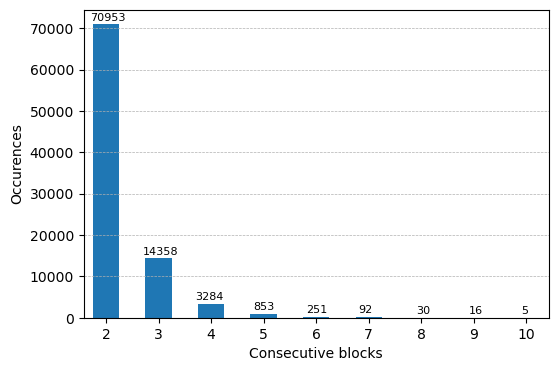

In [316]:
slc = df[(df['count'] >= 2) & (df['count'] <= 10)]

temp = slc['count'].unique()
temp.sort()

stat = slc.groupby(slc['count']).size().values

for i, x in enumerate(temp):
    stat[i] = stat[i]/x

fig, ax = plt.subplots(figsize =(6, 4))

ax.bar(temp, stat, width = 0.5)
ax.grid(axis='y', linestyle='--', linewidth=.5)


for i in range(0,2+1):
    plt.text(temp[i]-.3, stat[i]+1e3, s=f'{stat[i]}', fontdict=dict(fontsize=8))
    
for i in range(3,5+1):
    plt.text(temp[i]-.2, stat[i]+1e3, s=f'{stat[i]}', fontdict=dict(fontsize=8))
    
for i in range(6,len(temp)):
    plt.text(temp[i]-.1, stat[i]+1e3, s=f'{stat[i]}', fontdict=dict(fontsize=8))
    
left, right = plt.xlim()
ax.set_xlim(left+.25, right-0.25)

ax.set_ylabel('Occurences')
ax.set_xlabel('Consecutive blocks')

plt.xticks(temp)

plt.savefig(f'figures/occurences.png', bbox_inches='tight')
# show plot
plt.show()

In [ ]:
# Is there a pattern, to propose low gas blocks?
# "VALIDATOR for slot k+1 is buying the slot in order to submit an empty block just before the slot they are elected for"
# > Validators could be "unknown"

n, bins, patches = plt.hist(df[df['boosted']==True]['gas_used'], 50, density=True, facecolor='g', alpha=0.75)

temp = df[(df['boosted']==True) & (df['gas_used'] < 0.75e7)]

In [ ]:
temp

In [ ]:
print(temp.groupby(['builder_name']).size())

In [ ]:
pd.set_option("display.max_rows", None)
temp.groupby(['builder_name', 'count', 'position']).size().to_frame(name='vals')

### math

In [2]:
df = pd.read_csv('data/df_entity.csv')
df['date'] = pd.to_datetime(df['epoch'],  unit='s', utc=True)
fltr_name = 'entity'

In [ ]:
write down cases n<k n=k n>k and if k = 0
Bernouli (1 or 2)

p = .5
n = 3
k = 2

HHH  no !
HHT  yes
HTH  no
THH  yes
HTT  no
THT  no
TTH  no
TTT  yes
-> 2/8

In [ ]:
from IPython.display import display, Math, Latex
display(Math(r'p^{k}*(1-p)^{2}*(n-k-1)+2*p^{k}*(1-p)'))

In [ ]:
#What is the expected of exactly k consecutive heads in n tosses?

p = 50/100 #probability
n = 3 #tosses
k = 0 #k consecutive tosses


print('gesamt', p**k*(1-p)**2*(n-k-1)+2*p**k*(1-p))

print('term a', p**k*(1-p)**2*(n-k-1))
print('term b', 2*p**k*(1-p))

print('equation', f'{p}**{k}*(1-{p})**2*{(n-k-1)}+2*{p}**{k}*(1-{p})')

In [ ]:
display(Math(r'p^{k}*(1-p)^{2}*max(0,(n-k-1))+2*p^{k}*(1-p)'))

In [ ]:
#What is the probability of exactly k consecutive heads in n tosses?

p = 99/100 #probability
n = 3 #tosses
k = 1 #k consecutive tosses


print('gesamt', p**k*(1-p)**2*max(0,(n-k-1))+2*p**k*(1-p))

print('term a', p**k*(1-p)**2*max(0,(n-k-1)))
print('term b', p**k*(1-p)*2)

print('equation', f'{p}**{k}*(1-{p})**2*{max(0, n-k-1)}+2*{p}**{k}*(1-{p})')

In [175]:
def prob(c, p):
    # c = consecutive blocks
    # n = slots
    # p = share MEV boost
    
    x = symbols('x', real=True)

    c = c; n = 32; p = p

    xx = min(i for i in solve(1-x+(1-p)*p**c*x**(c+1)) if i > 1)
    qn = ((1 - p*xx) / ((c + 1 - c*xx)*(1-p))) * (1/(xx**(n+1)))
    
    return qn*100, (1-qn)*100

    

In [176]:
c = 2
p = 0.5

In [177]:
no_success, success = prob(c, p)

In [178]:
success

99.8672193149105

In [317]:
calc

,builder_name,slots,share,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10
0,flashbots,207603,0.2088,134724,24898,5319,1194,285,95,26,13,3,2
1,builder0x69,156094,0.1570,100699,18727,4134,916,256,66,21,2,4,0
2,bloxroute,110822,0.1114,82369,10893,1685,293,67,10,4,1,1,0
3,beaverbuild.org,105826,0.1064,69033,11596,2737,809,231,78,41,14,8,3
4,blocknative,32836,0.0330,29140,1565,140,21,10,2,0,0,0,0
5,https://eth-builder.com,30982,0.0312,25962,2051,249,39,3,0,0,0,0,0
6,coda_geth_linux,26921,0.0271,24295,1147,93,12,1,0,0,0,0,0
7,eden,7397,0.0074,7293,52,0,0,0,0,0,0,0,0
8,manifold,3478,0.0035,3427,24,1,0,0,0,0,0,0,0
Total,,681959,0.6858,476942,70953,14358,3284,853,251,92,30,16,5


In [302]:
expt = calc[['builder_name', 'share']]
expt = expt.drop('Total')

In [309]:
lst = []
for i in range(len(expt)):
    p = expt['share'].iloc[i]
    print(i, p)
    lst.append(montecarlo(p))

0 0.2088
1 0.157
2 0.1114
3 0.1064
4 0.033
5 0.0312
6 0.0271
7 0.0074
8 0.0035
9 0.6858


In [304]:
fill = [0] * 10
lst = [sublist[:n] + fill[len(sublist):] for sublist in lst]

In [305]:
for i in range(0,10):
    name = f'e_{i+1}'
    expt[name] = [item[i] for item in lst]

In [307]:
totals = expt.sum()
expt = expt.append(totals, ignore_index=True)
expt.rename(index={9: 'Total'}, inplace=True)
expt['builder_name'].iloc[9] = ''

/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_25380/2369748795.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  expt = expt.append(totals, ignore_index=True)
/var/folders/1l/dlmzk3fn30g9wwk6y58j36c00000gn/T/ipykernel_25380/2369748795.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expt['builder_name'].iloc[9] = ''


In [333]:
expt

,builder_name,share,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9,e_10
0,flashbots,0.2088,131943,26787,5287,1055,202,53,7,1,0,0
1,builder0x69,0.1570,112514,16991,2596,410,56,10,0,0,0,0
2,bloxroute,0.1114,88166,9496,1001,115,12,1,0,0,0,0
3,beaverbuild.org,0.1064,85049,8799,897,101,11,1,0,0,0,0
4,blocknative,0.0330,30696,973,19,0,0,0,0,0,0,0
5,https://eth-builder.com,0.0312,29026,877,22,0,0,0,0,0,0,0
6,coda_geth_linux,0.0271,25562,698,18,0,0,0,0,0,0,0
7,eden,0.0074,7342,58,0,0,0,0,0,0,0,0
8,manifold,0.0035,3378,14,0,0,0,0,0,0,0,0
Total,,0.6858,513676,64693,9840,1681,281,65,7,1,0,0


In [336]:
expt.rename(columns={'builder_name': 'builder entity'}, inplace=True)
expt.rename(columns={'slots': 'blocks'}, inplace=True)
expt.rename(columns={'e=1': 'k=1'}, inplace=True)
expt.rename(columns={'e=2': 'k=2'}, inplace=True)
expt.rename(columns={'e=3': 'k=3'}, inplace=True)
expt.rename(columns={'e=4': 'k=4'}, inplace=True)
expt.rename(columns={'e=5': 'k=5'}, inplace=True)
expt.rename(columns={'e=6': 'k=6'}, inplace=True)
expt.rename(columns={'e=7': 'k=7'}, inplace=True)
expt.rename(columns={'e=8': 'k=8'}, inplace=True)
expt.rename(columns={'e=9': 'k=9'}, inplace=True)
expt.rename(columns={'e=10': 'k=10'}, inplace=True)

expt['builder entity'].replace('coda_geth_linux', 'x85linux', inplace=True)
expt['builder entity'].replace('https://eth-builder.com', 'eth-builder.com', inplace=True)
expt['builder entity'].replace('', 'Total', inplace=True)

In [337]:
expt.to_csv('result_tables/expected_entity.csv', index=False)

In [301]:
random.seed(1)

def montecarlo(p):
    num_trials = int(len(df)/32)
    r = 2; n = 32; p = p

    epoch_proposals = [random.binomial(1, p, size=n) for i in range(num_trials)]

    consecutive_proposals = []
    for s in epoch_proposals:
        consecutive_proposals.append([sum(g) for i, g in groupby(s) if i == 1])

    flat = [item for sublist in consecutive_proposals for item in sublist]

    return [flat.count(x) for x in set(flat)]

[[1, 131943],
 [2, 26787],
 [3, 5287],
 [4, 1055],
 [5, 202],
 [6, 53],
 [7, 7],
 [8, 1]]

In [ ]:
p = np.round(len(df[df['builder_name'] == 'beaverbuild.org'])/1500,4)

print('In a dataset of', len(df), 'blocks', int(len(df)*12/60/60), 'hours we expect ..')
for i in [1,2,3,4,5]:
    c = i
    no_success, success = prob(c, p)
    print(i, 'consecutive blocks: Probability', np.round(float(success),2), '% - Instances:', np.round(float(success)/100*47,0))

print('.. proposed by the same builder')


In [ ]:
stat = df[df['builder_name'] == 'beaverbuild.org'].groupby(['count']).size().values

print('In a dataset of', len(df), 'blocks', int(len(df)*12/60/60), 'hours we find ..')

for i, x in enumerate(np.sort(df[df['builder_name'] == 'beaverbuild.org']['count'].unique())):
    stat[i] = stat[i]/x
    
    print(stat[i], 'instances of', i+1, 'consecutive blocks')
    
print('.. proposed by the same builder')

In [ ]:
## MATRIX
cons_blocks = np.arange(2,5+1) #cons_blocks
prob = np.arange(.1,.9+.05,.05)

In [ ]:
lst = []
for p in prob:
    lst_temp = []
    lst_temp.append(x)
    for c in cons_blocks:
        no_success, success = prob(c, p)
        lst_temp.append(success)
    
    for z in range(0, len(lst_temp)):
        try: 
            lst_temp[z] = np.round(float(lst_temp[z]), 2)
        except TypeError:
            lst_temp[z] = 100
        
    lst.append(lst_temp)
        

In [ ]:
df = pd.DataFrame(lst, columns =['probability', 'k=2', 'k=3', 'k=4', 'k=5', 'k=6', 'k=7', 'k=8', 'k=9', 'k=10'])
df = df.set_index('probability')
df

In [ ]:
print('If the market share of MEV boost is p=0.5, then we derive', (38.96/100)*225, 'k=5 consecutive blocks a day.')
print('If the market share of MEV boost is p=0.5, then we derive', (38.96/100)*6759, 'k=5 consecutive blocks a month.')
